In [1]:
# Using newly preprocessed subjects

import pickle

metadictname = '/home/anton/Documents/Tulane/Research/PNC_Good/PNC_agesexwrat.pkl'
alltsname = '/home/anton/Documents/Tulane/Research/PNC_Good/PNC_PowerTS_float2.pkl'

with open(metadictname, 'rb') as f:
    metadict = pickle.load(f)

with open(alltsname, 'rb') as f:
    allts = pickle.load(f)
    
print(list(metadict.keys()))
print(list(allts.keys()))
print('Complete')

['age', 'sex', 'wrat', 'missingage', 'missingsex', 'missingwrat', 'failedqc']
['emoid', 'nback', 'rest']
Complete


In [2]:
'''
Get subjects that have all tasks and paras specified
Functions for creating independent and response variables
'''

import numpy as np

def get_subs(allts, metadict, tasks, paras):
    # Get subs for all paras
    for i,para in enumerate(paras):
        tmpset = set([int(sub[4:]) for sub in allts[para].keys()])
        if i == 0:
            paraset = tmpset
        else:
            paraset = paraset.intersection(tmpset)
    # Get subs for all tasks
    for i,task in enumerate(tasks):
        tmpset = set([sub for sub in metadict[task].keys()])
        if i == 0:
            taskset = tmpset
        else:
            taskset = paraset.intersection(tmpset)
    # Remove QC failures
    allsubs = taskset.intersection(paraset)
    for badsub in metadict['failedqc']:
        try:
            allsubs.remove(int(badsub[4:]))
        except:
            pass
    return allsubs

def get_X(allts, paras, subs):
    X = []
    for para in paras:
        pX = [allts[para][f'sub-{sub}'] for sub in subs]
        pX = np.stack(pX)
        X.append(pX)
    return X

def get_y(metadict, tasks, subs):
    y = []
    for task in tasks:
        if task == 'age' or task == 'wrat':
            var = [metadict[task][sub] for sub in subs]
            var = np.array(var)
            y.append(var)
        if task == 'sex':
            maleness = [metadict[task][sub] == 'M' for sub in subs]
            maleness = np.array(maleness)
            sex = np.stack([maleness, 1-maleness], axis=1)
            y.append(sex)
    return y

subs = get_subs(allts, metadict, ['age', 'sex', 'wrat'], ['rest', 'nback', 'emoid'])
print(len(subs))

X = get_X(allts, ['rest', 'nback', 'emoid'], subs)
print(X[0].shape)

830
(830, 264, 124)


In [3]:
# TS to condensed FC

from scipy import signal

def butter_bandpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = [cutoff[0] / nyq, cutoff[1] / nyq]
    b, a = signal.butter(order, normal_cutoff, btype='band', analog=False)
    return b, a

def butter_bandpass_filter(data, cutoff, fs, order=5):
    b, a = butter_bandpass(cutoff, fs, order=order)
    y = signal.filtfilt(b, a, data)
    return y

tr = 1.83

def filter_design_ts(X):
    Xs = []
    for i in range(X.shape[0]):
        nX = butter_bandpass_filter(X[i], [0.01, 0.2], 1/tr)
        Xs.append(nX)
    return np.stack(Xs)

def ts_to_flat_fc(X):
    p = np.corrcoef(X)
    a,b = np.triu_indices(p[0].shape[0], 1)
    p = p[a,b]
    return p

ts = [np.stack([ts for ts in filter_design_ts(Xp)]) for Xp in X]
ts = [tsmod/np.linalg.norm(tsmod, axis=(-1), keepdims=True) for tsmod in ts]
print(ts[0].shape)

(830, 264, 124)


In [6]:
import itertools
import time

import torch
import torch.nn as nn
import torch.nn.functional as F

class LowRankCodes(nn.Module):
    '''
    ranks: array of rank for each codebook matrix
    '''
    def __init__(self, ranks):
        super(LowRankCodes, self).__init__()
        self.As = []
        for rank in ranks:
            A = nn.Parameter(1e-2*torch.randn(rank,264).float().cuda())
            self.As.append(A)
        self.As = nn.ParameterList(self.As)

    def forward(self):
        book = []
        for A in self.As:
            AA = A.T@A
            book.append(AA)
        return torch.stack(book)
    
class LowRankWeights(nn.Module):
    '''
    For a single modality!
    
    nsubs: number of subjects
    ncodes: number of pages in the codebook
    nt: number of timepoints
    '''
    def __init__(self, nsubs, ncodes, nt):
        super(LowRankWeights, self).__init__()
        self.w = nn.Parameter(1e-2*torch.rand(nsubs, ncodes, nt).float().cuda())

    def forward(self, sub, book):
        w = self.w[sub]
        return torch.einsum('pt,pab->abt', w, book)

def get_recon_loss(x, xhat):
    return mseLoss(xhat, x)

def get_smooth_loss_fc(xhat):
    before = xhat[:,:,:-1]
    after = xhat[:,:,1:]
    return torch.mean((before-after)**2)

def get_sub_fc(subts):
    return torch.einsum('at,bt->abt',subts,subts)

mseLoss = nn.MSELoss()

mod = 'emoid'
modidx = 2
modidx2 = 2

# Timeseries
x = torch.from_numpy(ts[modidx]).float().cuda()
x2 = torch.from_numpy(ts[modidx2]).float().cuda()

# Parameters
ntrain = 400
nbatch = 30
smooth_mult = 0.1
sparse_mult = 0#1e-3
nEpochs = 60
pPeriod = 40
ncodes = 800

print(f'Starting ncodes {ncodes}')
suborder = np.arange(x.shape[0])
np.random.shuffle(suborder)
suborder = suborder[:ntrain]

# Codebook and weights
lrc = LowRankCodes(ncodes*[1])
lrw = LowRankWeights(ntrain, ncodes, x.shape[-1])

# Optimizers
optim = torch.optim.Adam(itertools.chain(lrc.parameters(), lrw.parameters()), lr=1e-2, weight_decay=0)
sched = torch.optim.lr_scheduler.ReduceLROnPlateau(optim, patience=int(ntrain/nbatch)+5, factor=0.75, eps=1e-7)

t0 = time.time()

for epoch in range(nEpochs):
    for bstart in range(0,ntrain,nbatch):
        bend = bstart+nbatch
        if bend > ntrain:
            bend = ntrain
        optim.zero_grad()
        book = lrc()
        recon_loss = 0
        smooth_loss_fc = 0
        sparse_loss = 0
        for subidx in range(bstart, bend):
            # THE FOLLOWING 3 LINES MEAN LRW.W DOESN'T MATCH SUBJECTS UNLESS WE MAP THROUGH SUBORDER
            # WHICH IS OKAY SINCE WE RE-ESTIMATE WEIGHTS THROUGH THE DICTIONARY ANYWAY
            sub = suborder[subidx]
            xsub = get_sub_fc(x[sub])
            xhat = lrw(subidx, book)       
            recon_loss += get_recon_loss(xsub, xhat)
            smooth_loss_fc += smooth_mult*get_smooth_loss_fc(xhat)
        recon_loss /= (bend-bstart)
        smooth_loss_fc /= (bend-bstart)
#         sparse_loss = sparse_mult*torch.mean(torch.abs(lrw.w))
#         sparse_loss = sparse_mult*torch.mean(lrw.w*torch.log(lrw.w))
        totloss = recon_loss+smooth_loss_fc+sparse_loss
        totloss.backward()
        optim.step()
        sched.step(totloss)
    if epoch % 5 == 0 or epoch == nEpochs-1:
        print(f'{epoch} {bstart} recon: {[float(ls)**0.5 for ls in [recon_loss, smooth_loss_fc, sparse_loss]]} '
              f'lr: {sched._last_lr}')

t1 = time.time()
print(f'Completed dictionary estimation {t1-t0} sec')

# Weight estimation
book = lrc()

A = book.reshape(book.shape[0], -1).permute(1,0)
AA = A.T@A
codes = []

for sub in range(x2.shape[0]):
    B = get_sub_fc(x2[sub]).reshape(-1, x2.shape[-1])
    AB = A.T@B
    C,_,_,_ = torch.linalg.lstsq(AA+0.1*torch.eye(AA.shape[0]).float().cuda(),AB)
    codes.append(torch.from_numpy(C.detach().cpu().numpy()))
    if sub % 100 == 0:
        loss = mseLoss(A@C,B)**0.5
        print(f'Finished {sub} {loss}')

codes = torch.stack(codes)
print(codes.shape)
print('Finished weight estimation')

Starting ncodes 800
0 390 recon: [0.007500043348672013, 3.860506985701264e-06, 0.0] lr: [0.01]
5 390 recon: [0.006883078691428754, 0.0017804557386460708, 0.0] lr: [0.01]
10 390 recon: [0.005537352058350241, 0.0013123214834876277, 0.0] lr: [0.0075]
15 390 recon: [0.0052404185876923, 0.001377164614558995, 0.0] lr: [0.0075]
20 390 recon: [0.0074549523459427145, 0.0037510599250240068, 0.0] lr: [0.0075]
25 390 recon: [0.004840710858124293, 0.001528158124749764, 0.0] lr: [0.005625]
30 390 recon: [0.004866444639236265, 0.0016907561752082224, 0.0] lr: [0.00421875]
35 390 recon: [0.005734864816913099, 0.002579360154742626, 0.0] lr: [0.00421875]
40 390 recon: [0.004781534908689139, 0.0017677890534790095, 0.0] lr: [0.00421875]
45 390 recon: [0.005659487485949293, 0.002595226787360673, 0.0] lr: [0.00421875]
50 390 recon: [0.004781434857298235, 0.0018781448046148652, 0.0] lr: [0.00421875]
55 390 recon: [0.005880366352281003, 0.002866331896837145, 0.0] lr: [0.00421875]
59 390 recon: [0.0044357283975

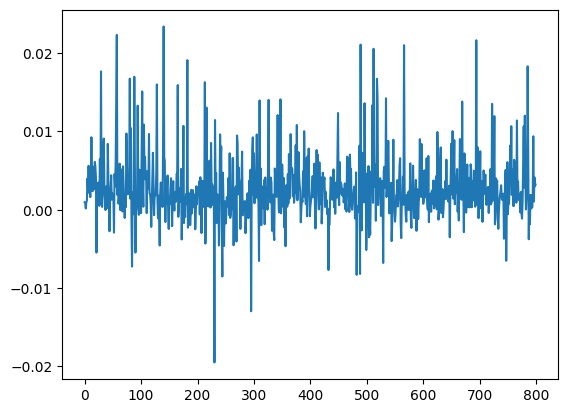

In [12]:
import matplotlib.pyplot as plt

codesmu = torch.mean(codes, dim=-1)
codesnp = codesmu.detach().cpu().numpy()
plt.plot(codesnp[2])
plt.show()

In [40]:
def znorm(x):
    x = x-torch.mean(x, dim=-1, keepdims=True)
    x = x/torch.std(x, dim=-1, keepdims=True)
    return x

y = get_y(metadict, ['age'], subs)[0]
yt = torch.from_numpy(y).float()
x1 = znorm(codesmu)
x2 = znorm(yt)
corr = torch.einsum('nd,n->d',x1,x2)
corr /= torch.std(x2)
corr /= x1.shape[0]
print(corr.shape)
print(max(corr))
print(min(corr))

torch.Size([800])
tensor(0.6137)
tensor(-0.4374)


In [154]:
idcs = torch.argsort(corr)
print(idcs[:5])
print(idcs[-5:])
print([float(corr[idcs[n]]) for n in range(5)])
print([float(corr[idcs[-n]]) for n in range(5,0,-1)])

tensor([295, 277, 488, 395, 499])
tensor([489, 631, 276, 503, 566])
[-0.43744415044784546, -0.39194610714912415, -0.3335561454296112, -0.3225354254245758, -0.32143592834472656]
[0.4146929979324341, 0.46011921763420105, 0.4989546537399292, 0.5412464141845703, 0.6136618852615356]


In [152]:
a,b = np.triu_indices(264)
flat = img[a,b]
ii = np.argsort(flat)
print(ii[-5:])
for jj in range(0,10,1):
    print((a[ii[jj]],b[ii[jj]]))

[22735  2946 22419 22421 22734]
(6, 108)
(6, 106)
(6, 11)
(6, 109)
(6, 178)
(6, 55)
(6, 62)
(6, 96)
(6, 192)
(6, 30)


In [169]:
from scipy.stats import t

thresh = 0.05/800
print(thresh)

n = 830
corr = [0.614,0.541,0.499,0.46,0.415,0.437,0.392,0.334,0.323,0.321]
for r in corr:
    tt = r*((n-2)**0.5)/((1-r**2)**0.5)
    p = 1-t.cdf(tt, n-2)
    print((tt,p))

6.25e-05
(3.772764289144824, 8.647470415945602e-05)
(22.384021897590372, 0.0)
(18.509929787323234, 0.0)
(16.568989955266453, 0.0)
(14.90732405572117, 0.0)
(13.125235730936836, 0.0)
(13.98022058339753, 0.0)
(12.261111113395362, 0.0)
(10.196393931573482, 0.0)
(9.8207223812053, 0.0)
(9.75290299999475, 0.0)


/tmp/ipykernel_180694/3961681948.py:12: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


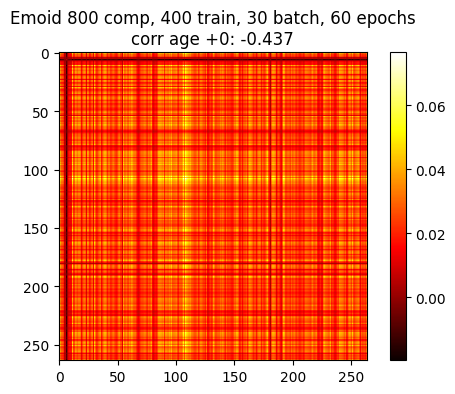

In [142]:
import matplotlib as mpl

fig,ax = plt.subplots(figsize=(6,4))

idx = 0
img = book[idcs[idx]].detach().cpu().numpy()

im = ax.imshow(img, cmap='hot')
fig.colorbar(mappable=im, ax=ax)
ax.set_title(f'Emoid 800 comp, 400 train, 30 batch, 60 epochs\ncorr age {idx:+d}: {corr[idcs[idx]]:+.3}')
fig.savefig(f'../../Work/LatSimEC/FigureAgeNetworks/age-800-idx{idx:+d}.pdf')
fig.show()

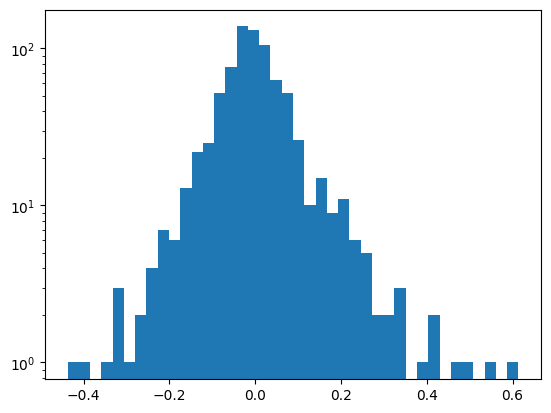

In [37]:
plt.hist(corr.detach().numpy(), bins=40, log=True)
plt.show()

In [26]:
# Show original correlations

p = np.stack([ts_to_flat_fc(ts) for ts in filter_design_ts(X[2])])
print(p.shape)

(830, 34716)


In [38]:
y = get_y(metadict, ['age'], subs)[0]
yt = torch.from_numpy(y).float()
x1 = znorm(torch.from_numpy(p).float())
x2 = znorm(yt)
corr = torch.einsum('nd,n->d',x1,x2)
corr /= torch.std(x2)
corr /= x1.shape[0]
print(corr.shape)
print(max(corr))
print(min(corr))

torch.Size([34716])
tensor(0.4614)
tensor(-0.3814)


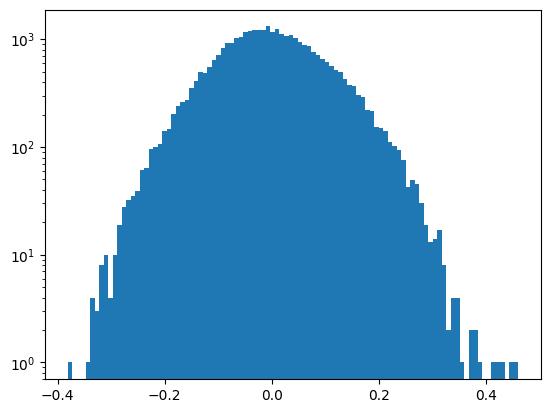

In [39]:
plt.hist(corr.detach().cpu().numpy(), bins=100, log=True)
plt.show()